## DL-LA-Tensorflow-Datatset-2

In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [11]:
import pandas as pd
import pandas as np

In [12]:
import os
import scipy.io as sio

In [13]:
## Loading MNIST dataset from keras
import keras
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
from keras.utils import to_categorical

In [15]:
## Importing required libraries
import numpy as np
import tensorflow.compat.v1 as tf
from sklearn.metrics import roc_auc_score, accuracy_score
s = tf.InteractiveSession()
tf.disable_v2_behavior()

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### Load Data

In [16]:
df_data1 = pd.read_csv('../DataFactory/FixedPlaintext/TS2_A.csv')

In [17]:
df_data1['label'] = 0

In [18]:
df_data2 = pd.read_csv('../DataFactory/FixedPlaintext/TS2_B.csv')

In [19]:
df_data2['label'] = 1

In [20]:
len(df_data1)

400000

### Create Label

In [21]:
df_label1 = df_data1['label']
df_data1 = df_data1.drop(['label'],axis=1)

In [22]:
df_label2 = df_data2['label']
df_data2 = df_data2.drop(['label'],axis=1)

In [23]:
df_data = pd.concat([df_data1,df_data2])
df_data = df_data.reset_index()
df_data = df_data.to_numpy()
df_data = np.delete(df_data, 0, axis=1)

In [24]:
len(df_data)

800000

In [25]:
df_label = pd.concat([df_label1,df_label2])
df_label = df_label.reset_index()
df_label = df_label.to_numpy()

In [26]:
df_label = df_label[:,-1]

### Split Label

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df_data,df_label,test_size=0.2,shuffle=True,stratify=df_label)

In [29]:
y_train = to_categorical(y_train,num_classes=2)

In [30]:
y_test = to_categorical(y_test,num_classes=2)

In [32]:
import numpy as np

In [33]:
X_train = np.array(X_train)

In [34]:
y_train = np.array(y_train)

In [37]:
X_test = np.array(X_test)

In [38]:
y_test = np.array(y_test)

In [39]:
## Defining various initialization parameters for 784-512-256-10 MLP model
num_classes = y_train.shape[1]
num_features = X_train.shape[1]
num_output = y_train.shape[1]
num_layers_0 = 120
num_layers_1 = 90
num_layers_2 = 50
num_layers_3 = 2
starter_learning_rate = 0.001
regularizer_rate = 0.1

In [40]:
# Placeholders for the input data
input_X = tf.placeholder('float32',shape =(None,num_features),name="input_X")
input_y = tf.placeholder('float32',shape = (None,num_classes),name='input_Y')
## for dropout layer
keep_prob = tf.placeholder(tf.float32)

In [41]:
## Initializing weigths and biases
hidden_output_0 = tf.layers.dense(input_X, units=num_layers_0)
hidden_output_0 = tf.layers.batch_normalization(hidden_output_0, training=True)
hidden_output_0 = tf.nn.relu(hidden_output_0)

hidden_output_1 = tf.layers.dense(hidden_output_0, units=num_layers_1)
hidden_output_1 = tf.layers.batch_normalization(hidden_output_1, training=True)
hidden_output_1 = tf.nn.relu(hidden_output_1)

hidden_output_2 = tf.layers.dense(hidden_output_1, units=num_layers_2)
hidden_output_2 = tf.layers.batch_normalization(hidden_output_2, training=True)
hidden_output_2 = tf.nn.relu(hidden_output_2)

hidden_output_3 = tf.layers.dense(hidden_output_2, units=num_layers_3)
predicted_y = tf.nn.softmax(hidden_output_3)

#predicted_y = tf.nn.softmax(hidden_output_3)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


In [42]:
## Defining the loss function
loss = tf.reduce_mean(tf.squared_difference(predicted_y, input_y))

In [43]:
## Variable learning rate
learning_rate = tf.train.exponential_decay(starter_learning_rate, 0, 5, 0.85, staircase=True)

## Adam optimzer for finding the right weight
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [44]:
## Metrics definition
correct_prediction = tf.equal(tf.argmax(y_train,1), tf.argmax(predicted_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [45]:
## Training parameters
batch_size = 1000
epochs=30
dropout_prob = 0.6
training_accuracy = []
training_loss = []
testing_accuracy = []
saver = tf.train.Saver()
s.run(tf.global_variables_initializer())
file_writer = tf.summary.FileWriter('./', tf.get_default_graph())

for epoch in range(epochs):    
    arr = np.arange(X_train.shape[0])
    np.random.shuffle(arr)
    for index in range(0,X_train.shape[0],batch_size):
        s.run(optimizer, {input_X: X_train[arr[index:index+batch_size]],
                          input_y: y_train[arr[index:index+batch_size]]})
    
    saver.save(s, './model.ckpt')
    training_accuracy.append(s.run(accuracy, feed_dict= {input_X: X_train, 
                                                         input_y: y_train}))
    training_loss.append(s.run(loss, {input_X: X_train, 
                                      input_y: y_train}))
    
    
    ## Evaluation of model
    testing_accuracy.append(accuracy_score(y_test.argmax(1), 
                                           s.run(predicted_y, {input_X: X_test}).argmax(1)))
    print("Epoch:{0}, Train loss: {1:.2f} Train acc: {2:.3f}, Test acc:{3:.3f}".format(epoch,
                                                                    training_loss[epoch],
                                                                    training_accuracy[epoch],
                                                                    testing_accuracy[epoch]))

Epoch:0, Train loss: 0.25 Train acc: 0.526, Test acc:0.512
Epoch:1, Train loss: 0.25 Train acc: 0.534, Test acc:0.514
Epoch:2, Train loss: 0.25 Train acc: 0.539, Test acc:0.513
Epoch:3, Train loss: 0.25 Train acc: 0.545, Test acc:0.515
Epoch:4, Train loss: 0.25 Train acc: 0.547, Test acc:0.513
Epoch:5, Train loss: 0.25 Train acc: 0.551, Test acc:0.514
Epoch:6, Train loss: 0.25 Train acc: 0.555, Test acc:0.509
Epoch:7, Train loss: 0.24 Train acc: 0.559, Test acc:0.511
Epoch:8, Train loss: 0.24 Train acc: 0.563, Test acc:0.510
Epoch:9, Train loss: 0.24 Train acc: 0.567, Test acc:0.508
Epoch:10, Train loss: 0.24 Train acc: 0.569, Test acc:0.509
Epoch:11, Train loss: 0.24 Train acc: 0.573, Test acc:0.508
Epoch:12, Train loss: 0.24 Train acc: 0.576, Test acc:0.508
Epoch:13, Train loss: 0.24 Train acc: 0.579, Test acc:0.505
Epoch:14, Train loss: 0.24 Train acc: 0.579, Test acc:0.508
Epoch:15, Train loss: 0.24 Train acc: 0.583, Test acc:0.507
Epoch:16, Train loss: 0.24 Train acc: 0.584, Test 

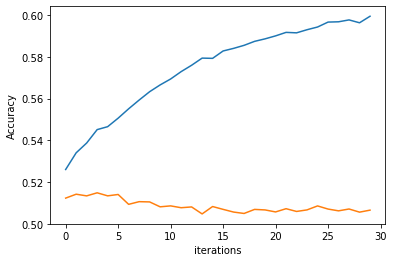

Train Accuracy: 0.60
Test Accuracy:0.51


In [46]:
## Plotting chart of training and testing accuracy as a function of iterations
iterations = list(range(epochs))
plt.plot(iterations, training_accuracy, label='Train')
plt.plot(iterations, testing_accuracy, label='Test')
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.show()
print("Train Accuracy: {0:.2f}".format(training_accuracy[-1]))
print("Test Accuracy:{0:.2f}".format(testing_accuracy[-1]))

### SA

In [47]:
dO_i = tf.gradients(predicted_y, tf.trainable_variables(),unconnected_gradients='zero')

In [48]:
gradients= None
gradients = s.run(dO_i, feed_dict= {input_X: X_train})

In [49]:
def calcLayer(inputLayer,outputLayer):
    tmpArr = []
    for i in inputLayer:
        tmpSUM = []
        for j in outputLayer:
            tmpSUM.append(j * i)
        tmpArr.append(sum(tmpSUM))
    return(tmpArr)

In [50]:
L1 = calcLayer(gradients[0],np.array(gradients[3]))
L2 = calcLayer(L1,np.array(gradients[7]))
L3 = calcLayer(L2,np.array(gradients[11]))
L4 = calcLayer(L3,np.array([gradients[13][0]]))

In [51]:
myTmp = []
tmpArr = []
for j in range(500,5000,150):
    gradients= None
    gradients = s.run(dO_i, feed_dict= {input_X: X_train[0:j]})

    
    
    L1 = calcLayer(gradients[0],np.array(gradients[3]))
    L2 = calcLayer(L1,np.array(gradients[7]))
    L3 = calcLayer(L2,np.array(gradients[11]))
    L4 = calcLayer(L3,np.array([gradients[13][0]]))
    tmpArr.append(np.max(L4))    
    
#myTmp.append(np.max(-np.log10(np.abs(L4))))

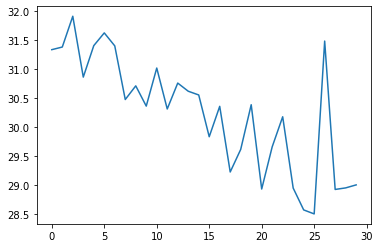

In [52]:
plt.plot(-np.log10(np.abs(tmpArr)))
plt.show()